In [1]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
from storm_masking_routines import interpolate_storm_path
from storm_masking_routines import get_dist_grid
from storm_masking_routines import closest_dist
from storm_masking_routines import calculate_storm_mask


In [ ]:
input_year=int(str(sys.argv[1]))
print ('processing year:', input_year)


In [ ]:
input_year = 2003
input_storm = 2
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

        if iyr_storm!=input_year:
            continue
        if input_storm!=inum_storm:
            continue

#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        lats = ds_storm_info.lat[0,:]
        lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180 #put -180 to 180
        dysince = ds_storm_info.time
        ds_storm_info.close()
#        print(ds_storm_info)
#        break

#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
#calculate size of box to get data in
        minlon,maxlon = min(lons.values)-10, max(lons.values)+10
        minlat,maxlat = min(lats.values)-10, max(lats.values)+10

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        min_date = min(tem_date)+dt.timedelta(days=-5)
#        max_date = max(tem_date)+dt.timedelta(days=5)
        minjdy = min_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min_date.year #create new time array that can be queried for year etc
        minmon =min_date.month #create new time array that can be queried for year etc
        minday =min_date.day #create new time array that can be queried for year etc
#        maxjdy = max_date.timetuple().tm_yday  #create new time array that can be queried for year etc
#        maxyear =max_date.year  #create new time array that can be queried for year etc
        print(minyear,minjdy)#,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+45             #calculate ssts for 30 days after storm
        
        #print(tdim,xdim,ydim)            
        
        #print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = dt.datetime(minyear,minmon,minday)+dt.timedelta(days=i)+dt.timedelta(hours=12)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)

#sst data   
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
            filename = dir_cmc + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction'])
            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
                ds_day = ds_day.sortby(ds_day.lon)
            ds_day.close()
            ds_day = ds_day.where(ds_day['mask'] == 1.) 
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            #ds_storm['time']=storm_date
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            if i==0:
                ds_storm_sst = ds_storm
            else:
                ds_storm_sst = xr.concat([ds_storm_sst,ds_storm],dim='time')

#sst climatology  --- this isn't used, should remove from dataset in next round
#            if storm_date.timetuple().tm_yday==366:
#                sjdy = '365'
#            filename='F:/data/sst/cmc/CMC0.2deg/v2/climatology/clim1993_2016' + sjdy.zfill(3) + '-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
#            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction','sq_sst'])
#            ds_day = ds_day.rename({'analysed_sst':'analysed_sst_clim','mask':'mask_clim'}) #, inplace = True)            
#            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
#                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
#                ds_day = ds_day.sortby(ds_day.lon)
#            ds_day.close()
#            ds_day = ds_day.where(ds_day['mask_clim'] == 1.) 
#            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
#            ds_storm = ds_storm.assign_coords(time=storm_date)
#            if iwrap==1:
#                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
#            if i==0:
#                ds_storm_sst_clim = ds_storm
#            else:
#                ds_storm_sst_clim = xr.concat([ds_storm_sst_clim,ds_storm],dim='time')           
            
#ccmp wind data, no masked data, a complete field
#            lyr, idyjl = 2015,1
#            storm_date = dt.datetime(2015,1,1)
            syr, smon, sdym, sjdy=str(storm_date.year),str(storm_date.month),str(storm_date.day),str(storm_date.timetuple().tm_yday)
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      
            ds=xr.open_dataset(ccmp_filename,drop_variables=['nobs'])
            ds_day = ds.mean(dim='time')     #take average across all 6 hourly data fields
            ds_day = ds_day.rename({'longitude':'lon','latitude':'lat'}) #, inplace = True)            
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_ccmp = ds_storm
            else:
                ds_storm_ccmp = xr.concat([ds_storm_ccmp,ds_storm],dim='time')
              
#ocean mixed layer depth from monthly data GODAS NOAA, lon 0 to 360, monthly data so interp to day
            #dir_godas='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/godas/'
            dir_godas = 'f:/data/model_data/godas/'
            if isave_mld_year != storm_date.year:
                filename = dir_godas + 'dbss_obml.' + syr + '.nc'
                ds_day_mld=xr.open_dataset(filename)
                if iwrap==0:
                    ds_day_mld.coords['lon'] = (ds_day_mld.coords['lon'] + 180) % 360 - 180
                    ds_day_mld = ds_day_mld.sortby(ds_day_mld.lon)
                ds_day_mld.close()
                isave_mld_year = storm_date.year
            ds_storm = ds_day_mld.interp(time = storm_date, lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_mld = ds_storm
            else:
                ds_storm_mld = xr.concat([ds_storm_mld,ds_storm],dim='time')            
            
#latent heat flux data, masked already set to NaN                
            filename = dir_flux + 'lh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_lhf = ds_storm
            else:
                ds_storm_lhf = xr.concat([ds_storm_lhf,ds_storm],dim='time')

#sensible heat flux data , masked already set to NaN                
            filename = dir_flux + 'sh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_shf = ds_storm
            else:
                ds_storm_shf = xr.concat([ds_storm_shf,ds_storm],dim='time')

#surface humid flux data   , masked already set to NaN              
            filename = dir_flux + 'qa_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_qa = ds_storm
            else:
                ds_storm_qa = xr.concat([ds_storm_qa,ds_storm],dim='time')

#air temp flux data   , masked already set to NaN              
            filename = dir_flux + 'ta_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_ta = ds_storm
            else:
                ds_storm_ta = xr.concat([ds_storm_ta,ds_storm],dim='time')
                
#        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst, ds_storm_sst_clim])
        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst])

        #calculate mask
#        print('caluculating mask')
#        ds_mask = calculate_storm_mask(ds_all,lats,lons)
#        ds_all['storm_mask']=ds_mask['storm_mask']
#        #dist to storm
#        print('calculating dist')
#        dist,index,stime,position = closest_dist(ds_all,ds_storm_info)
#        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['dist_from_storm_km']=dtem
#        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['closest_storm_index']=dtem
#        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['closest_storm_time']=dtem
#        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['side_of_storm']=dtem

        if iwrap==1:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)

        #calculate mask
        print('caluculating mask')
        ds_mask = calculate_storm_mask(ds_all,lats,lons)
        ds_all['storm_mask']=ds_mask['storm_mask']
        #dist to storm
        print('calculating dist')
        dist,index,stime,position,ds_storm_interp = closest_dist(ds_all,ds_storm_info)
        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['dist_from_storm_km']=dtem
        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_index']=dtem
        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_time']=dtem
        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['side_of_storm']=dtem

#add storm translation speed to storm information
        tdim_storm = ds_storm_interp.time.size
        storm_speed = ds_storm_interp.time.copy(deep=True)*np.nan    
        for i in range(0,tdim_storm-1):
            coords_1 = (ds_storm_interp.lat[0,i], ds_storm_interp.lon[0,i])  
            coords_2 = (ds_storm_interp.lat[0,i+1], ds_storm_interp.lon[0,i+1])  
            arclen_temp = geopy.distance.geodesic(coords_1, coords_2).km  #distance in km  
            storm_date1 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_storm_interp.time[0,i])))  
            storm_date2 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_storm_interp.time[0,i+1])))  
            arclen_time = storm_date2 - storm_date1
            arclen_hr = arclen_time / np.timedelta64(1, 'h')
            storm_speed[0,i]=arclen_temp/(arclen_hr)
        storm_speed[0,-1]=storm_speed[0,-2]
        ds_storm_interp['storm_speed']=storm_speed
    
        
        
        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
        wtem=np.empty([ydim,xdim])
        ptem=np.empty([ydim,xdim])
        stem=np.empty([ydim,xdim])
        for i in range(0,xdim):
            for j in range(0,ydim):
                storm_index = ds_all.closest_storm_index[j,i].data
                wtem[j,i]=ds_storm_interp.wind[0,int(storm_index)].data
                ptem[j,i]=ds_storm_interp.pres[0,int(storm_index)].data
                stem[j,i]=ds_storm_interp.storm_speed[0,int(storm_index)].data
        xrtem=xr.DataArray(wtem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_wind']=xrtem
        xrtem=xr.DataArray(ptem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_pres']=xrtem
        xrtem=xr.DataArray(stem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_speed']=xrtem
        
        #find max sst 5 days before storm location
        #first create an array with the storm crossover time (from nearest point) as an array
        sdate = np.empty([ydim,xdim], dtype=dt.datetime)    
        for i in range(0,xdim):
            for j in range(0,ydim):
                tem=date_1858+dt.timedelta(days=float(ds_all.closest_storm_time[j,i])) 
                sdate[j,i]=np.datetime64(tem)
        xsdate=xr.DataArray(sdate, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))    
        ds_all['closest_storm_time_np64']=xsdate
        #now use array of storm time to calculate prestorm sst
        sst0 = ds_all.dist_from_storm_km.copy(deep=True)
        for i in range(0,xdim):
            for j in range(0,ydim):
                #sst0[j,i] = ds_data.analysed_sst[:,j,i].interp(time=xsdate[j,i])
                sst0[j,i] = ds_all.analysed_sst[:,j,i].sel(time=slice(xsdate[j,i]-np.timedelta64(5,'D'),xsdate[j,i])).max()
        ds_all['sst_prestorm']=sst0

#now calculate coldwake information
        if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_interp['lon'] = np.mod(ds_storm_interp['lon'], 360)
        max_lat = ds_storm_interp.lat.max()

    #remove all data outsice 100km/800km or cold wake >0 or <-10
        if max_lat<0:
            cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
            ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) )       
        else:
            cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
            ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))))            
        subset = ds_all.where(cond)
          
        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
        date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
        coldwake_max=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_maxindex=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_hrtomaxcold=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_recovery=ds_all.sst_prestorm.copy(deep=True)*np.nan
#go through entire array lat/lon dims
        for i in range(0,xdim):
            for j in range(0,ydim):
                 #calculate the storm time for the closest collocated storm point then find the combined data index for closest time
                #this gives you the combined data storm index cross over
                storm_date64 = ds_all.closest_storm_time_np64[j,i]
                if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                    continue
                time_diff = subset.time-storm_date64
                storm_index = np.argmin(abs(time_diff)).data
                #now look for cold wake for 1 day before strom to 5 days after strom
                #caluclate hours to cold wake, maximum cold wake, hours until it returns to prestorm sst
                #there is NO filter on wheither coldwake large enough here, just does all points
                istart,iend = int(storm_index),int(storm_index)+5
                if iend>tdim:
                    iend=tdim
                if np.isnan(subset.sst_prestorm[j,i]):
                    continue
                coldwake_max[j,i] = (subset.analysed_sst[istart:iend,j,i]-subset.sst_prestorm[j,i]).min()
                itmp = np.argmin(subset.analysed_sst[istart:iend,j,i]-subset.sst_prestorm[j,i]).data
                coldwake_maxindex[j,i]=istart+itmp
                delay = subset.time[istart+itmp].values-subset.time[istart].values
                coldwake_hrtomaxcold[j,i]=delay / np.timedelta64(1, 'h')
                for k in range(istart+itmp,tdim):
                    sst_change = subset.analysed_sst[k,j,i]-subset.sst_prestorm[j,i]
                    if sst_change>-0.2:
                        break
                delay = subset.time[k].values-subset.time[istart].values
                coldwake_recovery[j,i]=delay / np.timedelta64(1, 'D')

        ds_all['coldwake_max']=coldwake_max
        ds_all['coldwake_maxindex']=coldwake_maxindex
        ds_all['coldwake_hrtomaxcold']=coldwake_hrtomaxcold
        ds_all['coldwake_dytorecovery']=coldwake_recovery
        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    




001 2002
002 2002
005 2002
007 2002
009 2002
010 2002
011 2002
012 2002
013 2002
014 2002
015 2002
017 2002
018 2002
019 2002
020 2002
021 2002
022 2002
023 2002
025 2002
027 2002
028 2002
030 2002
031 2002
033 2002
034 2002
035 2002
036 2002
037 2002
039 2002
040 2002
041 2002
042 2002
043 2002
046 2002
047 2002
048 2002
049 2002
050 2002
051 2002
052 2002
053 2002
054 2002
055 2002
056 2002
058 2002
060 2002
061 2002
063 2002
064 2002
066 2002
067 2002
068 2002
069 2002
070 2002
072 2002
075 2002
077 2002
081 2002
082 2002
083 2002
084 2002
002 2003
002annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2003\002annual_storm_info_extended.nc
0 38.375 88.125
0 199 [38.375      38.62626263 38.87752525 39.12878788 39.38005051] [87.11994949 87.37121212 87.62247475 87.87373737 88.125     ]
2002 313
caluculating mask
38.375 88.125
lons1,lons2: 0 68.125 82.125
calculating dist


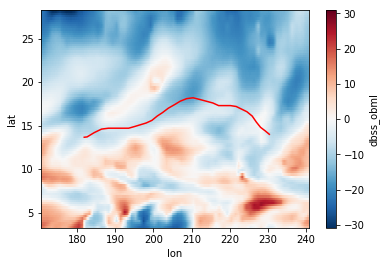

In [105]:
ds_all

<xarray.Dataset>
Dimensions:                  (lat: 99, lon: 280, time: 53)
Coordinates:
  * lat                      (lat) float64 3.375 3.628 3.88 ... 27.87 28.12
  * lon                      (lon) float64 170.6 170.9 171.1 ... 240.4 240.6
  * time                     (time) datetime64[ns] 2003-08-23T12:00:00 ... 2003-10-14T12:00:00
Data variables:
    uwnd                     (time, lat, lon) float64 -4.443 -4.623 ... 3.005
    vwnd                     (time, lat, lon) float64 2.471 2.552 ... -3.433
    date                     (time) float64 2.003e+05 2.003e+05 ... 2.003e+05
    timePlot                 (time) float64 2.004e+03 2.004e+03 ... 2.004e+03
    dbss_obml                (time, lat, lon) float64 79.45 80.14 ... 35.52
    lhtfl                    (time, lat, lon) float64 157.1 158.6 ... 52.99
    shtfl                    (time, lat, lon) float64 8.947 8.991 ... 6.275
    tmp2m                    (time, lat, lon) float64 29.19 29.16 ... 20.0 19.98
    hum2m                  

6
4
17
2003-09-09T12:00:00.000000000 2003-08-29T12:00:00.000000000
11.0


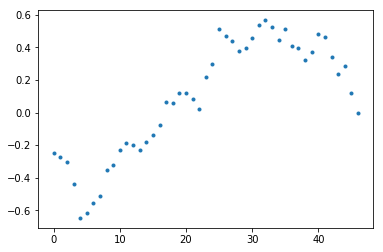

In [88]:
print(istart)
print(itmp)
print(k)
print(subset.time[k].data,subset.time[istart].data)
print(coldwake_recovery[j,i].data)
plt.plot(subset.analysed_sst[istart:,j,i]-subset.sst_prestorm[j,i],'.')

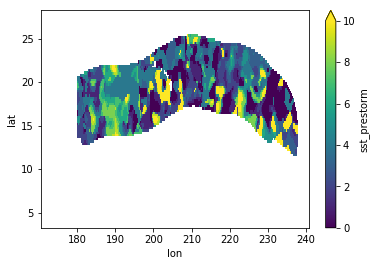

In [91]:
coldwake_recovery.plot(vmin=0,vmax=10)

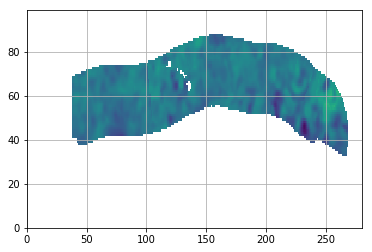

In [81]:
plt.pcolormesh(coldwake_max,vmin=-1,vmax=1)
#coldwake_max.plot()
#plt.plot(ds_storm_interp.lon[0,:]+360,ds_storm_interp.lat[0,:],'r')
#plt.plot(ds_storm_interp.lon[0,0]+360,ds_storm_interp.lat[0,0],'r*')
plt.grid()

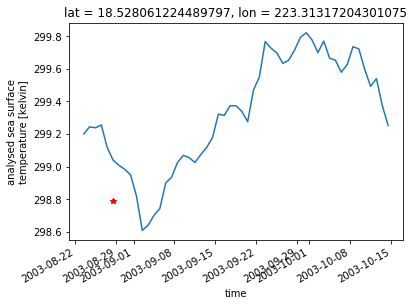

In [82]:
subset.analysed_sst[:,60,210].plot()
plt.plot(subset.time[istart],subset.analysed_sst[istart,60,240],'r*')
plt.plot(subset.time[istart],subset.analysed_sst[istart,60,240],'r*')

In [50]:
subset.time[istart]
print(subset.lon[240].data,subset.lat[60].data)


230.8400537634409 18.528061224489797


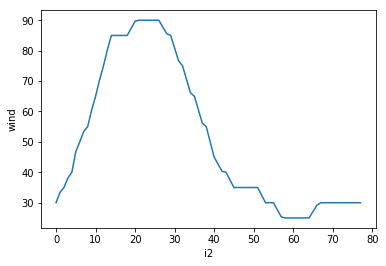

In [57]:
ds_storm_interp.wind[0,:].plot()

In [59]:
ds_storm_interp.time[0,25]

<xarray.DataArray 'time' ()>
array(52882.220588)

In [61]:
ds_storm_interp.time[0,0:25]

<xarray.DataArray 'time' (i2: 25)>
array([52879.25    , 52879.420455, 52879.5     , 52879.65625 , 52879.75    ,
       52879.920455, 52880.      , 52880.170455, 52880.25    , 52880.383929,
       52880.5     , 52880.633929, 52880.75    , 52880.883929, 52881.      ,
       52881.125   , 52881.25    , 52881.375   , 52881.5     , 52881.617188,
       52881.734375, 52881.75    , 52881.875   , 52882.      , 52882.110294])
Dimensions without coordinates: i2